In [386]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN

from sklearn.metrics import silhouette_samples

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap

In [387]:
data = pd.read_csv('german_credit_data.csv', na_values=' ')

data.head()

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,0,67,male,2,own,NaN,little,1169,6,radio/TV
1,1,22,female,2,own,little,moderate,5951,48,radio/TV
2,2,49,male,1,own,little,NaN,2096,12,education
3,3,45,male,2,free,little,little,7882,42,furniture/equipment
4,4,53,male,2,free,little,little,4870,24,car


Замечаем, что имеется неименованный столбец с порядковыми номерами строк, удаляем его.

In [388]:
data = data.drop("Unnamed: 0", axis=1)

In [389]:
data.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,67,male,2,own,NaN,little,1169,6,radio/TV
1,22,female,2,own,little,moderate,5951,48,radio/TV
2,49,male,1,own,little,NaN,2096,12,education
3,45,male,2,free,little,little,7882,42,furniture/equipment
4,53,male,2,free,little,little,4870,24,car


In [390]:
data.shape

(1000, 9)

In [391]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   817 non-null    object
 5   Checking account  606 non-null    object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
dtypes: int64(4), object(5)
memory usage: 70.4+ KB


Видим, что столбцы Saving accounts и Checking account имеют пропущенные данные.

Т.к. данные столбца Checking account являются уточненными данными столбца Saving accounts, то пропущенные данные в столбце Checking account берем из столбца Saving accounts, а столбец Saving accounts удаляем.

In [392]:
sa = data.iloc[:]["Saving accounts"]
cha = data.iloc[:]["Checking account"]

for idx in range(cha.shape[0]):
  if type(cha[idx]) is float:
    cha[idx] = sa[idx]


In [393]:
data = data.drop("Saving accounts", axis=1)

Удаляем все строки, где есть прорущенные значения в столбце Checking account.

In [394]:
data = data.dropna(how="any", axis=0)

In [395]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 901 entries, 0 to 999
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               901 non-null    int64 
 1   Sex               901 non-null    object
 2   Job               901 non-null    int64 
 3   Housing           901 non-null    object
 4   Checking account  901 non-null    object
 5   Credit amount     901 non-null    int64 
 6   Duration          901 non-null    int64 
 7   Purpose           901 non-null    object
dtypes: int64(4), object(4)
memory usage: 63.4+ KB


Преобразуем категориальные переменные.

In [396]:
# Формируем список имен столбцов с категориальными признаками
col_names = [col_name for col_name in data.columns if data[col_name].dtype.name == "object"]

label_encoder = LabelEncoder()

for col_name in col_names:
  data[col_name] = label_encoder.fit_transform(data[col_name])

In [397]:
data.head()

,Age,Sex,Job,Housing,Checking account,Credit amount,Duration,Purpose
0,67,1,2,1,0,1169,6,5
1,22,0,2,1,1,5951,48,5
2,49,1,1,1,0,2096,12,3
3,45,1,2,0,0,7882,42,4
4,53,1,2,0,0,4870,24,1


**АЛГОРИТМЫ**

Стандартизируем данные.
Стандартизация требуется, т.к. все алгоритмы кластеризации оценивают расстояние между точками, поэтому все признаки должны быть приведены к одному масштабу.



In [398]:
sc = StandardScaler()
data_std = sc.fit_transform(data)

In [399]:
def silhouette_plot(data, labels):
  cluster_labels = np.unique(labels)
  n_clusters = cluster_labels.shape[0]

  silhouette_vals = silhouette_samples(data, labels, metric="euclidean")

  y_ax_lower, y_ax_upper = 0, 0
  yticks = []
  for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[labels == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(float(i) / n_clusters)

    plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, edgecolor="none", color=color)
    yticks.append((y_ax_lower + y_ax_upper) / 2.)
    y_ax_lower += len(c_silhouette_vals)

  c_silhouette_avg = np.mean(c_silhouette_vals)
  plt.axvline(c_silhouette_avg, color="red", linestyle="--")
  plt.yticks(yticks, cluster_labels + 1)
  plt.ylabel("Кластер")
  plt.xlabel("Коэф. силуэта")
  plt.show()
  

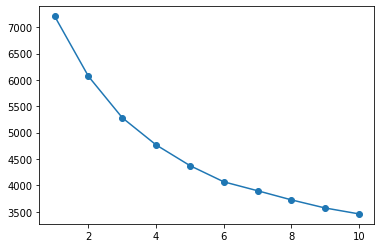

In [400]:
distortions = []

for i in range(1, 11):
  km = KMeans(n_clusters=i, n_init=10, max_iter=300, random_state=0)

  km.fit(data_std)

  distortions.append(km.inertia_)

plt.plot(range(1, 11), distortions, marker='o')
plt.show()

Методом локтя определяем кол-во кластеров равным около 5.

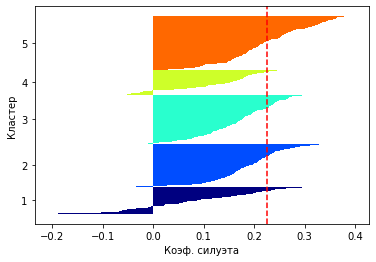

In [401]:
km = KMeans(n_clusters=5, n_init=20, max_iter=300, random_state=0)

y_km = km.fit_predict(data_std)

silhouette_plot(data_std, y_km)



Проверим, если возмем 4 кластера

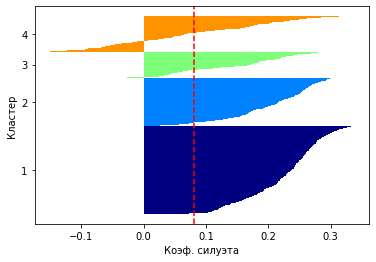

In [402]:
km = KMeans(n_clusters=4, n_init=20, max_iter=300, random_state=0)

y_km = km.fit_predict(data_std)

silhouette_plot(data_std, y_km)

Видно, что средний коэф. уменьшился и один кластер стал более разбросанным.

Проверим, если возьмем 6 кластеров.

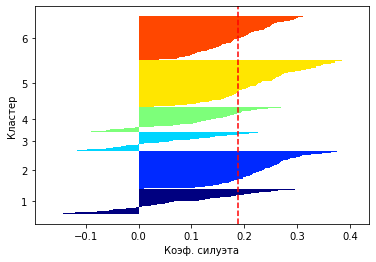

In [403]:
km = KMeans(n_clusters=6, n_init=20, max_iter=300, random_state=0)

y_km = km.fit_predict(data_std)

silhouette_plot(data_std, y_km)

Средний коэф. меньше, чем при 5.

Наш выбор - это 5 кластеров

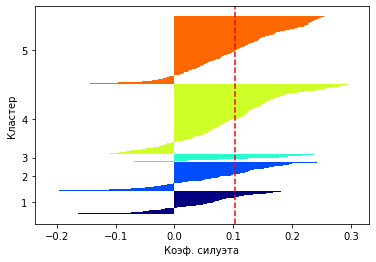

In [404]:
ac = AgglomerativeClustering(n_clusters=5, affinity="euclidean", linkage="complete")

labels = ac.fit_predict(data_std)

silhouette_plot(data_std, labels)

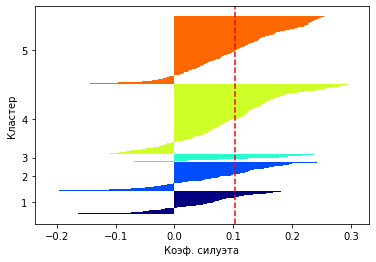

In [405]:
db = DBSCAN(eps=0.2, min_samples=5, metric="euclidean")

y_db = ac.fit_predict(data_std)

silhouette_plot(data_std, y_db)

По графикам силуэта можно сделать вывод, что данные можно разделить на 5 кластеров, но кластеры не имеют четких границ и разделение условно. В данном случае лучше всех выделяет кластеры самый простой алгоритм KMeans. Необходима дальнейшая пред. обработка данных, возможно, использование других алгоритмов кодирования категориальных признаков.

DBScan сам определил также 5 кластеров.

**Визуализация данных**

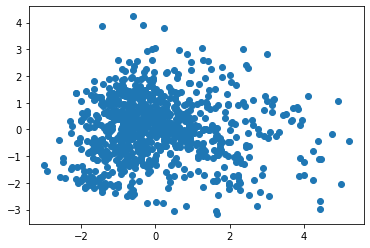

In [406]:
pca = PCA(n_components=2)

data_pca = pca.fit_transform(data_std)

plt.scatter(data_pca[:, 0], data_pca[:, 1])

Данный график не позволяет сделать какие-то выводы.

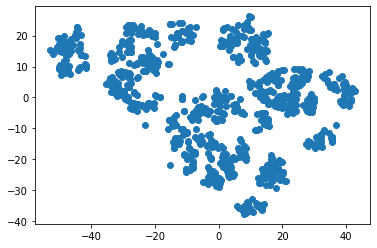

In [407]:
data_tsne = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(data_std)

plt.scatter(data_tsne[:, 0], data_tsne[:, 1])

Есть какие-то нечетко различимые кластеры

[]

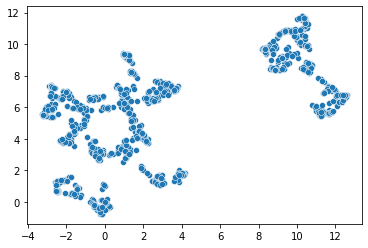

In [408]:
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(data_std)

sns.scatterplot(
    x=embedding[:, 0], 
    y=embedding[:, 1], 
    #hue=y_sample.astype(int), 
    palette="CMRmap", 
    legend='full'
)
plt.setp(ax, xticks=[], yticks=[])

Тоже что-то есть, но нечеткие кластеры.

Графики подтверждают методы кластеризации, что можно выделить кластеры, но они нечеткие, нет однозначных границ.

**Анализ данных кластеров.**

In [409]:
km = KMeans(n_clusters=5, n_init=20, max_iter=300, random_state=0)

y_km = km.fit_predict(data_std)

In [458]:
data_cluster1 = data[y_km == 0]
data_cluster2 = data[y_km == 1]
data_cluster3 = data[y_km == 2]
data_cluster4 = data[y_km == 3]
data_cluster5 = data[y_km == 4]

In [459]:
df1 = pd.DataFrame(data_cluster1.mean(), columns=["cluster1"])
df2 = pd.DataFrame(data_cluster2.mean(), columns=["cluster2"])
df3 = pd.DataFrame(data_cluster3.mean(), columns=["cluster3"])
df4 = pd.DataFrame(data_cluster4.mean(), columns=["cluster4"])
df5 = pd.DataFrame(data_cluster5.mean(), columns=["cluster5"])

df = pd.concat([df1, df2, df3, df4, df5], axis=1)

df

,cluster1,cluster2,cluster3,cluster4,cluster5
Age,35.959677,38.438776,31.339367,38.051724,34.213115
Sex,0.750000,0.979592,0.000000,0.732759,1.000000
Job,2.346774,1.826531,1.764706,1.853448,1.852459
Housing,0.838710,1.005102,1.316742,1.017241,1.053279
Checking account,0.548387,0.403061,0.420814,2.758621,0.377049
Credit amount,8491.500000,2597.857143,2214.633484,2277.413793,2319.491803
Duration,39.943548,16.974490,17.090498,18.000000,18.454918
Purpose,2.088710,0.821429,3.226244,3.000000,4.655738


Видно, что есть кластеры только с мужчинами и только с женщинами, есть смешанные. Люди среднего возраста берут наибольшую сумму на самый длительный срок.

In [490]:
data_std_cluster1 = pd.DataFrame(data_std[y_km == 0], columns=data.columns)
data_std_cluster2 = pd.DataFrame(data_std[y_km == 1], columns=data.columns)
data_std_cluster3 = pd.DataFrame(data_std[y_km == 2], columns=data.columns)
data_std_cluster4 = pd.DataFrame(data_std[y_km == 3], columns=data.columns)
data_std_cluster5 = pd.DataFrame(data_std[y_km == 4], columns=data.columns)

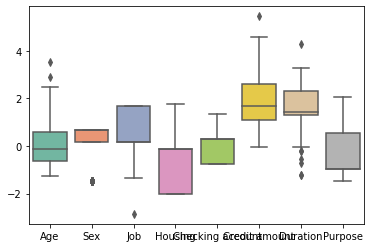

In [511]:
ax = sns.boxplot(data=data_std_cluster1, orient="v", palette="Set2")

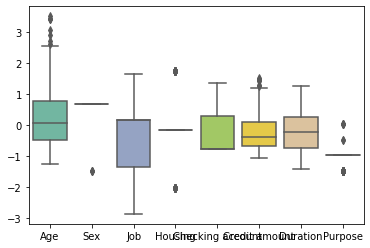

In [507]:
ax = sns.boxplot(data=data_std_cluster2, orient="v", palette="Set2")

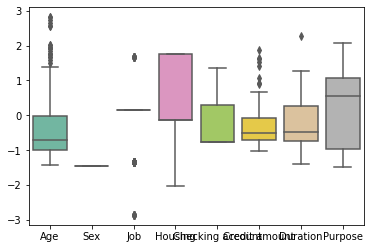

In [497]:
ax = sns.boxplot(data=data_std_cluster3, orient="v", palette="Set2")

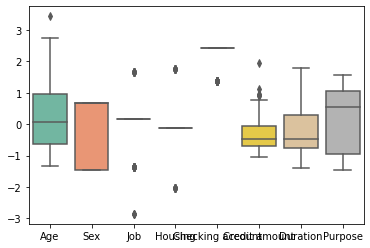

In [509]:
ax = sns.boxplot(data=data_std_cluster4, orient="v", palette="Set2")

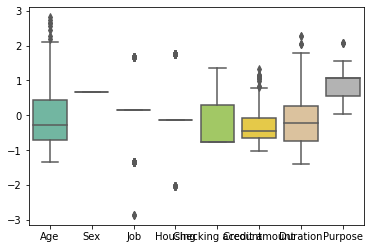

In [499]:
ax = sns.boxplot(data=data_std_cluster5, orient="v", palette="Set2")

Кластер 1 – это люди самого среднего возраста (это именно золотая середина), имеют низкий или средний достаток, с небольшим преобладанием женского пола, берут наибольшую сумму криедита на наиболее длительный срок на конкретные несколько целей.

Кластер 3 – только мужчины. Берут средние суммы на небольшой срок на все возможные цели.

Кластер 5 – только женщины, немного постарше мужчин в кластере 3. Берут средние суммы на небольшой срок на более узкие цели.

Кластер 2 – это теже женщины с теми же мыслями только немного старше и желающие еще меньше, чем в кластере 5, более уверенные в своем доходе и берут побольше сумму на чуть меньший срок.

Кластер 4 – это люди среднего возраста с хорошим достатком, берут небольшие суммы на небольшой срок для разнообразных целей.